In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import analysis.lib.sim.electron_nuclear_sim2 as nvs
plt.style.use('ggplot')

In [195]:
NV = nvs.noisy_NV_system(inc_nitrogen=True, pulse_shape='Hermite')
NV.set_mw_amp(0.80)
NV.set_mw_detuning(35e6)
NV.recalculate()

../analysis/lib/sim/electron_nuclear_sim2.py:207: UserWarning: No carbon params passed, using dummy params!
  warnings.warn('No carbon params passed, using dummy params!')


In [196]:
exp = nvs.NV_experiment(NV)

In [197]:
g_seq = exp.gate_sequence()
g_seq.ye()
g_seq.wait_gate(lambda : tau)
g_seq.ye()

In [198]:
res = []
for tau in np.arange(1e-6, 150e-6, 0.5e-6):
    exp.reset_init_state()
    exp.apply_gates(g_seq)
    res.extend([exp.measure_e()])

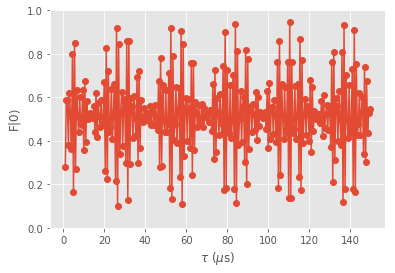

In [199]:
plt.plot(np.arange(1, 150, 0.5), np.array(res), 'o-')
plt.ylim(0,1)
plt.xlabel(r'$\tau$ ($\mu$s)')
plt.ylabel(r'F|0$\rangle$');

In [2]:
import qinfer as qi

/opt/anaconda/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/opt/anaconda/lib/python3.6/site-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [234]:
class SuperEasyModel(qi.FiniteOutcomeModel):
    
    def __init__(self):
        super(SuperEasyModel, self).__init__(self)
        self.NV = nvs.noisy_NV_system(inc_nitrogen=True, pulse_shape='Hermite')
        self.exp = nvs.NV_experiment(self.NV)
        
        self.g_seq = self.exp.gate_sequence()
        self.g_seq.ye()
        self.g_seq.wait_gate(lambda : self.tau)
        self.g_seq.ye()
    
    @property
    def n_modelparams(self):
        return 2
    
    @property
    def is_n_outcomes_constant(self):
        return True
    
    def n_outcomes(self, expparams):
        return 2
    
    def are_models_valid(self, modelparams):
        return np.all(modelparams != 0, axis=1)
    
    @property
    def expparams_dtype(self):
        return [('tau', 'float', 1)]
    
    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(SuperEasyModel, self).likelihood(outcomes, modelparams, expparams)
        
        # Next, since we have a two-outcome model, everything is defined by
        # Pr(0 | modelparams; expparams), so we find the probability of 0
        # for each model and each experiment.
                
        pr0 = np.empty((len(modelparams), len(expparams)))
        for i, mp in enumerate(modelparams):
            #print(mp)
            mw_detuning, mw_amp = mp
            #print('hello', mw_detuning, mw_detuning.shape)
            self.NV.set_mw_detuning(np.asscalar(mw_detuning))
            self.NV.set_mw_amp(np.asscalar(mw_amp))
            self.NV.recalculate()
            for j, self.tau in enumerate(expparams['tau']):
                self.exp.reset_init_state()
                self.exp.apply_gates(self.g_seq)
                pr0[i,j] = self.exp.measure_e()
        
        # Now we use pr0_to_likelihood_array to turn this two index array
        # above into the form expected by SMCUpdater and other consumers
        # of likelihood().
        return qi.FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [235]:
sem = SuperEasyModel()

../analysis/lib/sim/electron_nuclear_sim2.py:207: UserWarning: No carbon params passed, using dummy params!
  warnings.warn('No carbon params passed, using dummy params!')


In [236]:
modelp = np.array(((35e6, 0.7), ))
expp = np.empty((100,), dtype = sem.expparams_dtype)
expp['tau'] = np.linspace(1e-6, 100e-6, 100)

In [237]:
measures = sem.simulate_experiment(modelp, expp, repeat=5000)

(0, 1)

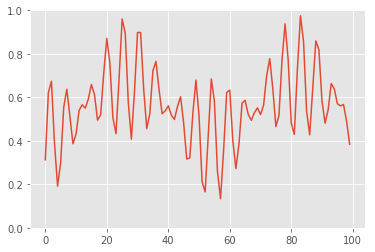

In [238]:
plt.plot(1 - measures.mean(axis=0)[0])
plt.ylim(0,1)

In [247]:
true_model = np.array(((33e6, 0.75),))
prior = qi.ProductDistribution(qi.UniformDistribution([20e6, 40e6]), qi.UniformDistribution([0, 1]))
updater = qi.SMCUpdater(sem, 30, prior)

In [248]:
for samples in range(100):
    experiment = np.empty((1,), dtype = sem.expparams_dtype)
    experiment['tau'] = np.random.random() * 100e-6
    #print(experiment['tau'])
    outcome = sem.simulate_experiment(true_model, experiment, repeat=500)
    #print(outcome)
    updater.update(outcome, experiment)
    print(updater.est_mean(), np.sqrt(updater.est_covariance_mtx().diagonal()))

[  3.20195201e+07   6.71652801e-01] [  5.65032441e+06   1.84616634e-01]
[  3.15830290e+07   6.33109662e-01] [  5.54393574e+06   2.06046790e-01]
[  3.10936775e+07   5.85147700e-01] [  5.64620482e+06   2.21775979e-01]
[  3.06428376e+07   5.29848029e-01] [  5.79347425e+06   2.26334751e-01]
[  3.03051326e+07   4.76401800e-01] [  5.80485055e+06   2.26534901e-01]
[  2.98797196e+07   6.42695036e-01] [  5.12551960e+06   1.73801872e-01]
[  3.04926845e+07   6.95633794e-01] [  4.95612768e+06   1.33610525e-01]
[  3.00928313e+07   6.55891285e-01] [  5.18568182e+06   1.42592537e-01]
[  2.97020835e+07   6.34890578e-01] [  5.22568038e+06   1.51291273e-01]
[  2.92972543e+07   6.10343493e-01] [  5.28128162e+06   1.57945339e-01]
[  2.95202206e+07   6.47046543e-01] [  4.75771963e+06   1.28850326e-01]
[  2.93122089e+07   6.30907788e-01] [  4.78647598e+06   1.32706260e-01]


KeyboardInterrupt: 

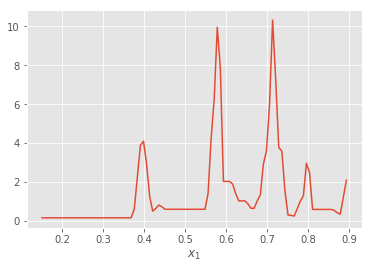

In [251]:
updater.plot_posterior_marginal(1)